# Diabetic Foot Ulcer Classification (DFUC)

## Import Libraries

In [1]:
# https://drive.google.com/drive/folders/1R-ol77knFF3lmLjRvTIOPwvgnKCg_2jc?usp=drive_link
# https://drive.google.com/drive/folders/1R-ol77knFF3lmLjRvTIOPwvgnKCg_2jc?usp=drive_link

In [2]:
!pip install gdown

In [4]:
!gdown --id 1R-ol77knFF3lmLjRvTIOPwvgnKCg_2jc

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:142: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1R-ol77knFF3lmLjRvTIOPwvgnKCg_2jc

but Gdown can't. Please check connections and permissions.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns 
import sklearn

## Load Data

In [2]:
# Define Constants
TRAIN_PATH = '../input/diabetic-foot-ulcer-dfu/DFU/Patches'
TEST_PATH = '../input/diabetic-foot-ulcer-dfu/DFU/TestSet'

BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CLASSES = 2
EPOCHS = 200

In [3]:

train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'validation',
    seed = 0
)

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


In [4]:
# Load Test Dataset
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(TEST_PATH + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)']


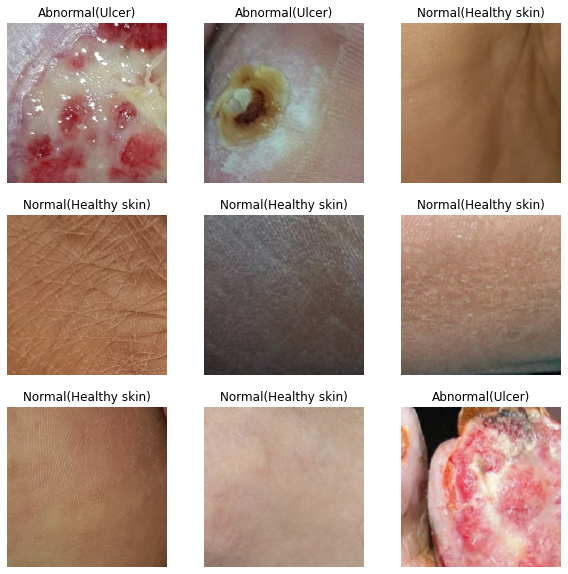

In [7]:
# Visualize the training dataset
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

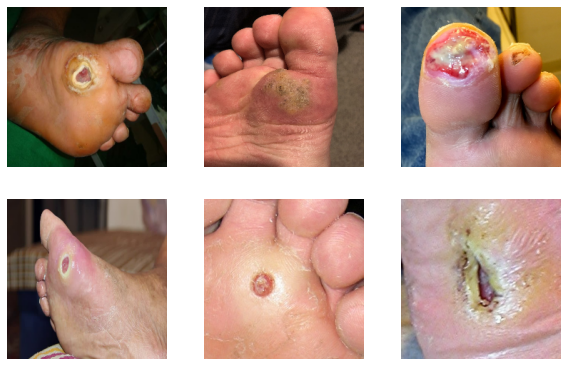

In [8]:
# Visualize the testing dataset
plt.figure(figsize = (10, 10))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

## Data Augmentation

In [9]:

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

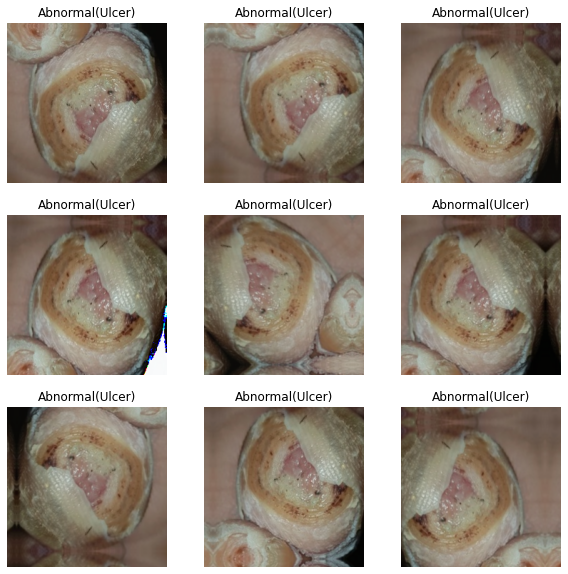

In [10]:
plt.figure(figsize = (10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [12]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Model

In [13]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)

In [14]:
# Initialize Model
def build_model():
    inputs = layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = img_augmentation(inputs)
    
    model = EfficientNetB0(include_top = False, weights = 'imagenet', input_tensor = x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "sigmoid", name = "pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=1e-3)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy"]
    )
    
    model.summary()
    
    return model

In [16]:
model = build_model()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           img_augmentation[1][0]           
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
_______________________________________________________________________________________

## Training

In [19]:
history = model.fit(train_ds, validation_data = validation_ds, 
                    callbacks = [lr_callback, stop_callback],
                    epochs = EPOCHS, verbose = 1)

Epoch 1/200
27/27 [==============================] - 24s 307ms/step - loss: 0.2559 - accuracy: 0.9289 - val_loss: 0.3530 - val_accuracy: 0.8057
Epoch 2/200
27/27 [==============================] - 6s 224ms/step - loss: 0.1493 - accuracy: 0.9609 - val_loss: 0.7559 - val_accuracy: 0.6967
Epoch 3/200
27/27 [==============================] - 6s 227ms/step - loss: 0.0974 - accuracy: 0.9668 - val_loss: 1.3643 - val_accuracy: 0.5782
Epoch 4/200
27/27 [==============================] - 6s 224ms/step - loss: 0.0600 - accuracy: 0.9822 - val_loss: 0.8452 - val_accuracy: 0.7583
Epoch 5/200
27/27 [==============================] - 6s 225ms/step - loss: 0.0720 - accuracy: 0.9775 - val_loss: 0.5123 - val_accuracy: 0.8626
Epoch 6/200
27/27 [==============================] - 6s 226ms/step - loss: 0.0556 - accuracy: 0.9822 - val_loss: 0.2509 - val_accuracy: 0.9242
Epoch 7/200
27/27 [==============================] - 6s 227ms/step - loss: 0.0252 - accuracy: 0.9893 - val_loss: 0.0987 - val_accuracy: 0.971

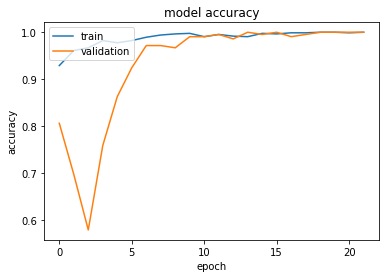

In [20]:
# Plot curves
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

## Prediction

In [17]:
print("Trying")

Trying


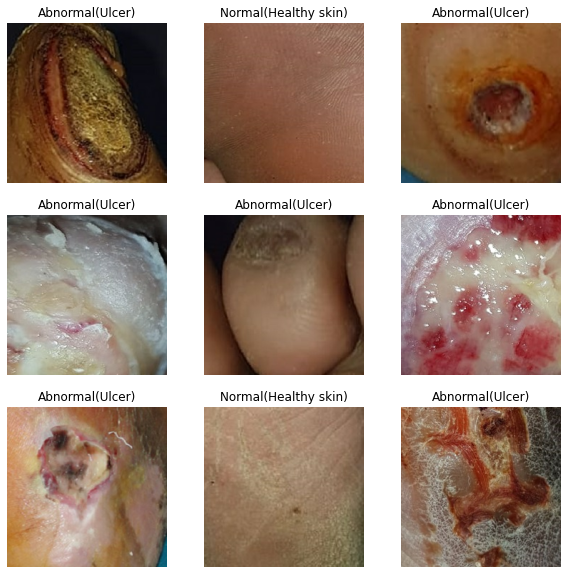

In [21]:
# Testing on Training Set
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        prediction = np.argmax(model.predict(np.array([images[i]])), axis = 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[prediction[0]])
        plt.axis("off")

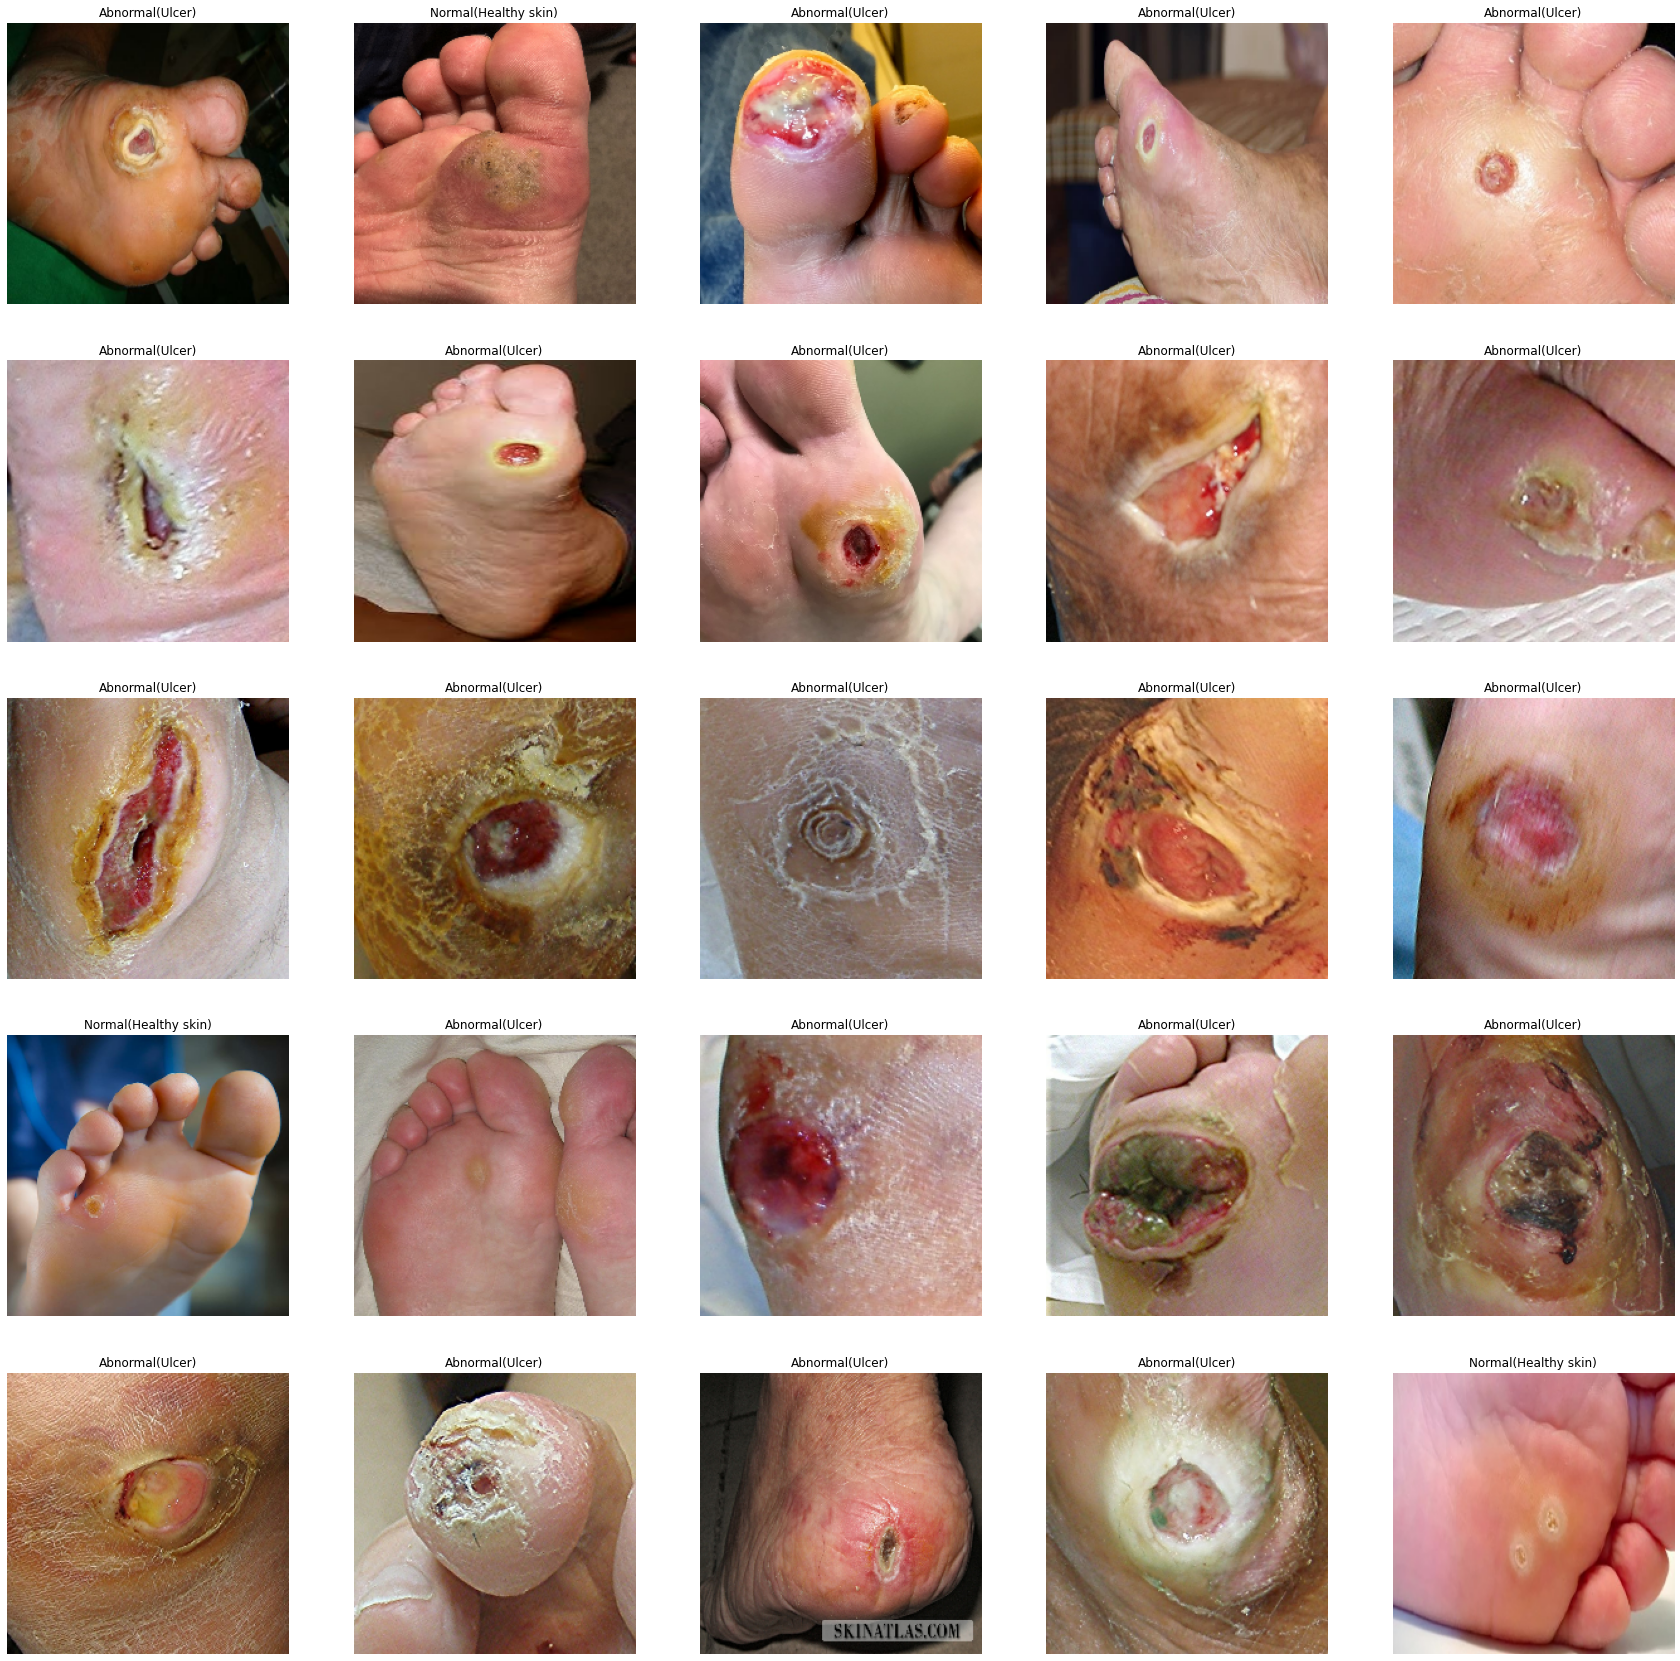

In [22]:
# Testing on Test Set
plt.figure(figsize = (30, 30))
plt.tight_layout()

i = 0
for images in test_ds.take(25):
    ax = plt.subplot(5, 5, i + 1)
    prediction = np.argmax(model.predict(np.array([images])), axis = 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[prediction[0]])
    plt.axis("off")
    i += 1